In [70]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import joblib
import os

seed=456

In [105]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

model_path = config["model"]["path"]
output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)




## Logistic Regression

In [106]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(random_state=seed)

param_grid = {
#    'C': [0.001, 0.01, 0.1, 1, 10, 100,],      decomment for every change of dataset
    'C': [0.105,0.11,0.115],           ## comment if u change the dataset
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8079
 Standard deviation across validation folds: 0.0081
Best hyperparameters found: {'C': 0.11, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8079


# KNN

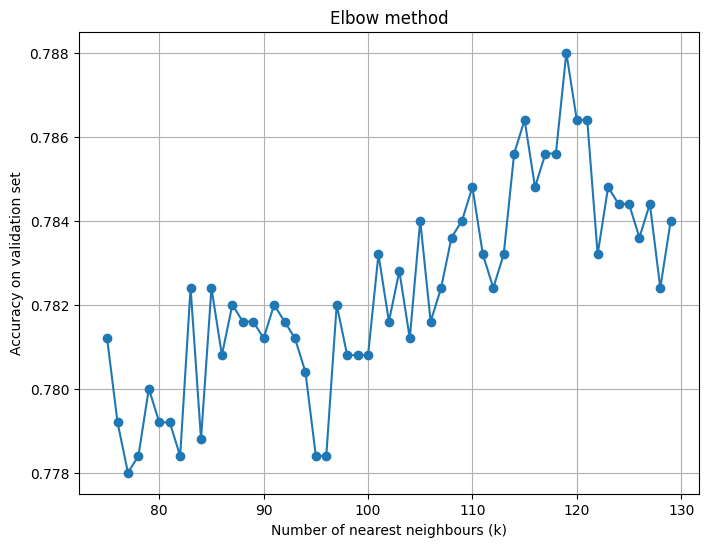

Best k: 119
Accuracy for validation set: 0.7880
Kfold with optimal k:
Mean of accuracy in folds: 0.7747
Stddev of accuracy in folds: 0.0104


,n_neighbors,119
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [107]:
### This is the KNN classifier
# an important thing is that we have a lot of feature and, in order to reduce dimensionality we can apply pca
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# Hyperparameters
k_values = range(75, 130)   # testiamo k da 1 a 30
n_splits = 5              # 5-fold cross-validation

# applying PCA for reduction of dimensionality and scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_tr_elb, X_val_elb, y_tr_elb, y_val_elb= train_test_split(X_train, y_train, test_size=0.25,random_state=seed, shuffle=True)



# building elbow method
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_tr_elb, y_tr_elb)
    y_pred = knn.predict(X_val_elb)
    acc = accuracy_score(y_val_elb, y_pred)
    accuracies.append(acc)

# plot elbow
plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()


# Best k
best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

# Kfold with the best k
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
best_knn = KNeighborsClassifier(n_neighbors=best_k)

cv_scores = cross_val_score(best_knn, X_train, y_train, cv=kf, scoring='accuracy')

print("Kfold with optimal k:")
print(f"Mean of accuracy in folds: {cv_scores.mean():.4f}")
print(f"Stddev of accuracy in folds: {cv_scores.std():.4f}")

# Last training with all the data
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train, y_train)


# BINARY TREES


# SUBMISSIONS


In [66]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [67]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
